# Comparison with EventDisplay

**Purpose of this notebook:**

Compare IRF and Sensitivity as computed by pyirf and EventDisplay on the same DL2 results

**Notes:**

The following results correspond to:

- La Palma site
- Zd 20 deg, Az 180 deg and 0 deg
- 50 h observation time
- Point-like IRFs for diffuse gammas
- 0-1 deg offset

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
    - [G-H cut](#G-H-cut)
    - [Multiplicity cut](#Multiplicity-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [1]:
import os

import numpy as np
import uproot
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable
from matplotlib.ticker import ScalarFormatter

from pyirf.binning import bin_center

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

## Input data

In [3]:
offset = 0  # It can be set to 0, 1, 2, 3, 4 or 5
fov_min = offset * u.deg
fov_max = (offset + 1) * u.deg

### _EventDisplay_

The input data for the IRFs provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects.

In [4]:
# Path of EventDisplay IRF data in the user's local setup
indir = "../../data/"
irf_file_event_display = "DESY.g20201203.V3.ID0NIM3LST3MST3SST3SCMST3.prod5b-LaPalma-20deg-sq10-LL.N.D25-4LSTs09MSTs-MSTN.180000s.root"

irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by pyirf.
The cuts are optimized independently for each event type selection and for the whole dataset (standard).

In [5]:
pyirf_file = indir + 'point_like_irfs.fits.gz'
pyirf_file_event_type_1 = indir + 'point_like_irfs_event_type_1.fits.gz'
pyirf_file_event_type_2 = indir + 'point_like_irfs_event_type_2.fits.gz'
pyirf_file_event_type_3 = indir + 'point_like_irfs_event_type_3.fits.gz'

## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut
[back to top](#Table-of-contents)

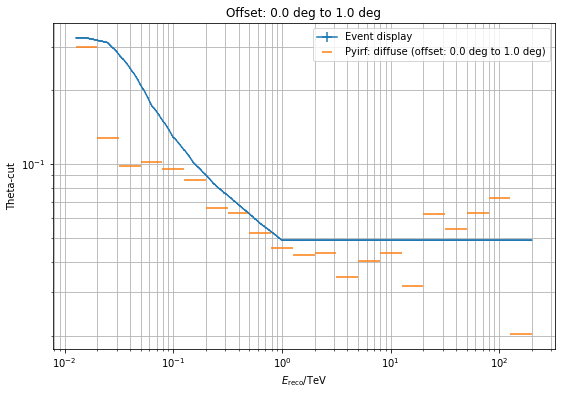

In [7]:
th_cut_pyirf = QTable.read(pyirf_file, hdu='THETA_CUTS')[1:-1]
th_cut_ed, edges, offset_bins = irf_eventdisplay["ThetaCut_offaxis"].to_numpy()
th_cut_ed = th_cut_ed[:, offset]
yerr = irf_eventdisplay["ThetaCut_offaxis"].errors()[:, offset]
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, th_cut_ed, xerr=xerr, yerr=yerr, label='Event display')

plt.errorbar(
    0.5 * (th_cut_pyirf['low'][:, offset] + th_cut_pyirf['high'][:, offset]).to_value(u.TeV),
    th_cut_pyirf['cut'][:, offset].to('deg').value,
    xerr=0.5 * (th_cut_pyirf['high'][:, offset] - th_cut_pyirf['low'][:, offset]).to_value(u.TeV),
    ls='',
    label='Pyirf: diffuse (offset: {} to {})'.format(fov_min, fov_max),
)

plt.legend()
plt.title('Offset: {} to {}'.format(fov_min, fov_max))
plt.ylabel('Theta-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')
plt.grid(which="both")

None # to remove clutter by mpl objects

### G-H cut
[back to top](#Table-of-contents)

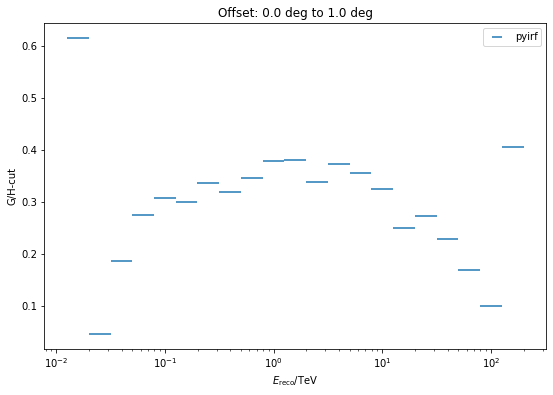

In [8]:
from astropy.table import QTable


gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1]


plt.errorbar(
    0.5 * (gh_cut['low'][:, offset] + gh_cut['high'][:, offset]).to_value(u.TeV),
    gh_cut['cut'][:, offset],
    xerr=0.5 * (gh_cut['high'][:, offset] - gh_cut['low'][:, offset]).to_value(u.TeV),
    ls='',
    label='pyirf',
)

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.title('Offset: {} to {}'.format(fov_min, fov_max))
plt.xscale('log')

None # to remove clutter by mpl objects

### Multiplicity cut
[back to top](#Table-of-contents)

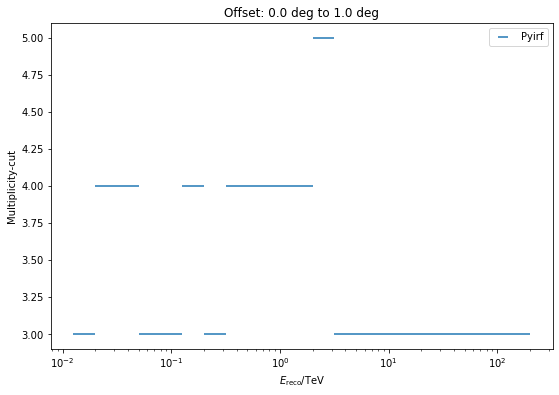

In [9]:
multi_cut = QTable.read(pyirf_file, hdu='MULTIPLICITY_CUTS')[1:-1]

plt.errorbar(
    0.5 * (multi_cut['low'][:, offset] + multi_cut['high'][:, offset]).to_value(u.TeV),
    multi_cut['cut'][:, offset],
    xerr=0.5 * (multi_cut['high'][:, offset] - multi_cut['low'][:, offset]).to_value(u.TeV),
    ls='',
    label='Pyirf',
)

plt.legend()
plt.ylabel('Multiplicity-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.title('Offset: {} to {}'.format(fov_min, fov_max))
plt.xscale('log')

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [10]:
def calculate_and_format_sensitivity(pyirf_file):
    # [1:-1] removes under/overflow bins
    sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]

    # make it print nice
    sensitivity['reco_energy_low'].info.format = '.3g'
    sensitivity['reco_energy_high'].info.format = '.3g'
    sensitivity['reco_energy_center'].info.format = '.3g'
    sensitivity['relative_sensitivity'].info.format = '.2g'
    sensitivity['flux_sensitivity'].info.format = '.3g'

    for k in filter(lambda k: k.startswith('n_'), sensitivity.colnames):
        sensitivity[k].info.format = '.1f'

    return sensitivity

In [11]:
sensitivity_alltypes = calculate_and_format_sensitivity(pyirf_file)
sensitivity_type1 = calculate_and_format_sensitivity(pyirf_file_event_type_1)
sensitivity_type2 = calculate_and_format_sensitivity(pyirf_file_event_type_2)
sensitivity_type3 = calculate_and_format_sensitivity(pyirf_file_event_type_3)

[3.7831244e-10 1.8776545e-11 6.7530152e-12 1.8098073e-12 9.2347094e-13
 5.8834708e-13 4.1830366e-13 2.9486231e-13 2.3526341e-13 1.8096275e-13
 1.7441869e-13 1.6052517e-13 1.7443000e-13 2.0581685e-13 3.0035447e-13
 4.3796366e-13 6.4510664e-13 1.0411357e-12 1.9661349e-12 2.6641694e-12
 7.1380458e-12]
3.5228609960593274e-11 / 3.783124369327595e-10 = 0.09312041191723955
8.748390739367645e-12 / 1.8776544555287877e-11 = 0.4659212302672544
3.8481728542076684e-12 / 6.7530152476902305e-12 = 0.5698451303695604
1.6412525971321432e-12 / 1.8098072953470767e-12 = 0.9068659416677791
9.696800487793738e-13 / 9.234709351380044e-13 = 1.0500385143517958
6.446381433074565e-13 / 5.883470793888179e-13 = 1.0956766267576519
4.780127954248682e-13 / 4.183036566868942e-13 = 1.1427411350187338
3.539971032324843e-13 / 2.948623062295347e-13 = 1.2005505476746705
2.9370497910592897e-13 / 2.352634146524091e-13 = 1.2484090632615557
2.3457825224166455e-13 / 1.80962748041677e-13 = 1.296279233047674
2.1330890018948971e-13 

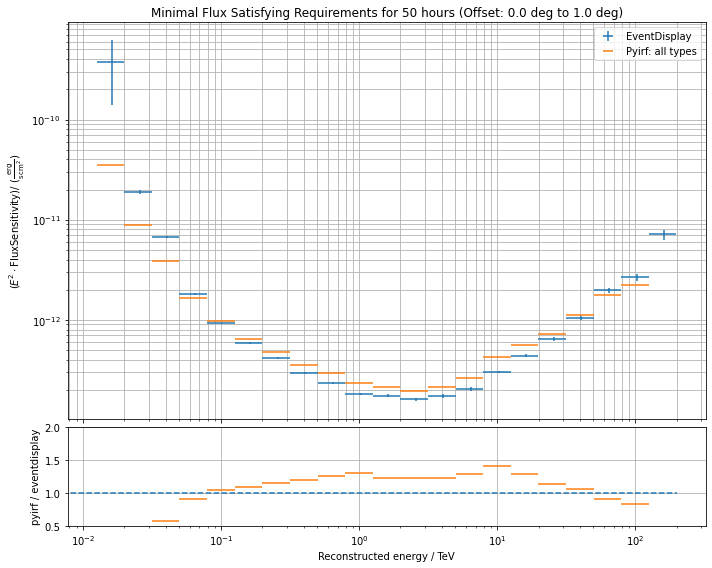

In [12]:
# Get data from event display file
y, edges, offset_bins = irf_eventdisplay["DiffSens_offaxis"].to_numpy()
y = y[:, offset]
yerr = irf_eventdisplay["DiffSens_offaxis"].errors()[:, offset]
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)

fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True, figsize=(10,8)
)

ax_sens.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=yerr,
    label="EventDisplay",
    ls=''
)

unit = u.Unit('erg cm-2 s-1')

print(y)
def plot_sensitivity(sensitivity, axis, axis_ratio, label, color, y):
    
    e = sensitivity['reco_energy_center'][:, offset]
    w = (sensitivity['reco_energy_high'][:, offset] - sensitivity['reco_energy_low'][:, offset])
    s = (e**2 * sensitivity['flux_sensitivity'][:, offset])


    axis.errorbar(
        e.to_value(u.TeV),
        np.array(s.to_value(unit)),
        xerr=w.to_value(u.TeV) / 2,
        ls='',
        color=color,
        label=label,
    )
    ratios = s.to_value(unit)/y
    for i, y1 in enumerate(s.to_value(unit)):
        print("{} / {} = {}".format(y1, y[i], ratios[i]))
    axis_ratio.plot([0, 200], [1, 1], '--')
    axis_ratio.errorbar(
        e.to_value(u.TeV), np.array(ratios),
        xerr=w.to_value(u.TeV)/2,
        ls='',
        color=color,
    )
    
plot_sensitivity(sensitivity_alltypes, ax_sens, ax_ratio, "Pyirf: all types", "C1", y)

ax_ratio.set_xlabel("Reconstructed energy / TeV")
ax_ratio.set_ylabel('pyirf / eventdisplay')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours '+'(Offset: {} to {})'.format(fov_min, fov_max))
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)
fig.savefig("Sensitivity_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

inf / 2.1987968874968174e-11 TeV / (cm2 s) = inf cm2 s / TeV
9.363201343766117e-12 / 5.460316018669166e-12 TeV / (cm2 s) = 1.7147727918590678 cm2 s / TeV
4.077068976592691e-12 / 2.4018405789630737e-12 TeV / (cm2 s) = 1.697476931775734 cm2 s / TeV
1.908010233505864e-12 / 1.0243892978482567e-12 TeV / (cm2 s) = 1.8625831385720886 cm2 s / TeV
1.1747512150705043e-12 / 6.052266823780017e-13 TeV / (cm2 s) = 1.9410102846999056 cm2 s / TeV
7.75977464405754e-13 / 4.023514821197027e-13 TeV / (cm2 s) = 1.9286059549667438 cm2 s / TeV
5.878277242528756e-13 / 2.983521200352671e-13 TeV / (cm2 s) = 1.9702481892315382 cm2 s / TeV
4.1434932116988034e-13 / 2.2094761321583742e-13 TeV / (cm2 s) = 1.8753283420405829 cm2 s / TeV
3.183981827272336e-13 / 1.8331622923039644e-13 TeV / (cm2 s) = 1.73687940267996 cm2 s / TeV
2.72645981843509e-13 / 1.464122290037495e-13 TeV / (cm2 s) = 1.862180390932555 cm2 s / TeV
2.366182122535911e-13 / 1.3313694361959453e-13 TeV / (cm2 s) = 1.7772543504503782 cm2 s / TeV
2.315428

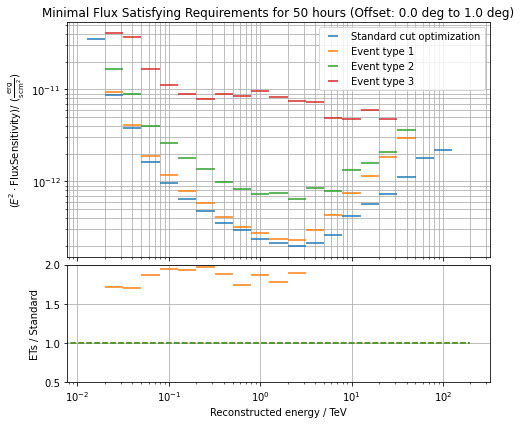

In [13]:
e = sensitivity_alltypes['reco_energy_center'][:, offset]
w = (sensitivity_alltypes['reco_energy_high'][:, offset] - sensitivity_alltypes['reco_energy_low'][:, offset])
s = (e**2 * sensitivity_alltypes['flux_sensitivity'][:, offset])

fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True, figsize=(7,6)
)

ax_sens.errorbar(
    e.to_value(u.TeV),
    np.array(s.to_value(unit)),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label="Standard cut optimization"
)

plot_sensitivity(sensitivity_type1, ax_sens, ax_ratio, "Event type 1", "C1", s)
plot_sensitivity(sensitivity_type2, ax_sens, ax_ratio, "Event type 2", "C2", s)
plot_sensitivity(sensitivity_type3, ax_sens, ax_ratio, "Event type 3", "C3", s)

ax_ratio.set_xlabel("Reconstructed energy / TeV")
ax_ratio.set_ylabel('ETs / Standard')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours '+'(Offset: {} to {})'.format(fov_min, fov_max))
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)
fig.savefig("Sensitivity_by_ET_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

In [14]:
area = QTable.read(pyirf_file, hdu='EFFECTIVE AREA')[0]
area

ENERG_LO [44],ENERG_HI [44],THETA_LO [6],THETA_HI [6],"EFFAREA [6,44]"
TeV,TeV,deg,deg,m2
float64,float64,float64,float64,float64
0.0 .. 199.52623149688972,0.012589254117941675 .. inf,0.0 .. 5.0,1.0 .. 6.0,1.5396915468306556 .. 2694.314411787212


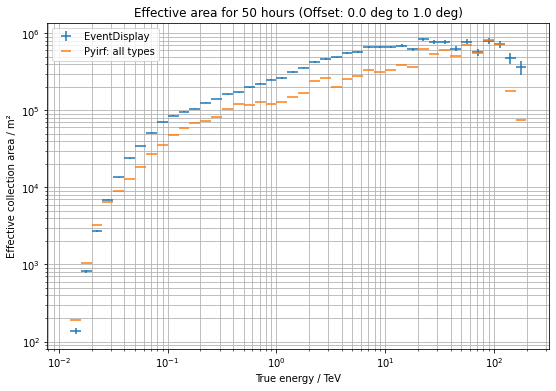

In [15]:
# Data from EventDisplay
y, edges, offset_bins = irf_eventdisplay["EffectiveAreaEtrue_offaxis"].to_numpy()
y = y[:, offset]
yerr = irf_eventdisplay["EffectiveAreaEtrue_offaxis"].errors()[:, offset]

x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

def plot_effective_area(pyirf_file, label):

    area = QTable.read(pyirf_file, hdu='EFFECTIVE AREA')[0]

    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1,offset],
        xerr=0.5 * (area['ENERG_HI'] - area['ENERG_LO']).to_value(u.TeV)[1:-1],
        ls='',
        label=label,
    )

plot_effective_area(pyirf_file, 'Pyirf: all types')
    
# Style settings
plt.title('Effective area for 50 hours (Offset: {} to {})'.format(fov_min, fov_max))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()
plt.savefig("EffectiveArea_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

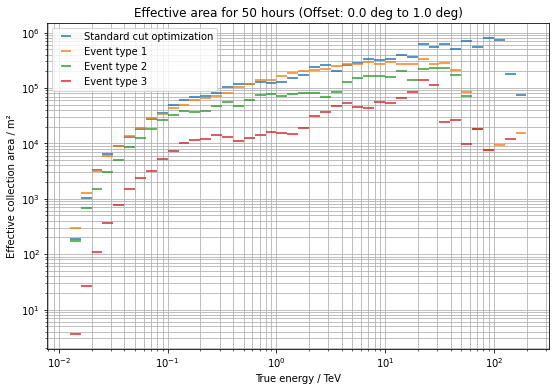

In [16]:
plot_effective_area(pyirf_file, 'Standard cut optimization')
plot_effective_area(pyirf_file_event_type_1, "Event type 1")
plot_effective_area(pyirf_file_event_type_2, "Event type 2")
plot_effective_area(pyirf_file_event_type_3, "Event type 3")
    
# Style settings
plt.title('Effective area for 50 hours (Offset: {} to {})'.format(fov_min, fov_max))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()
# plt.savefig("EffectiveArea_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

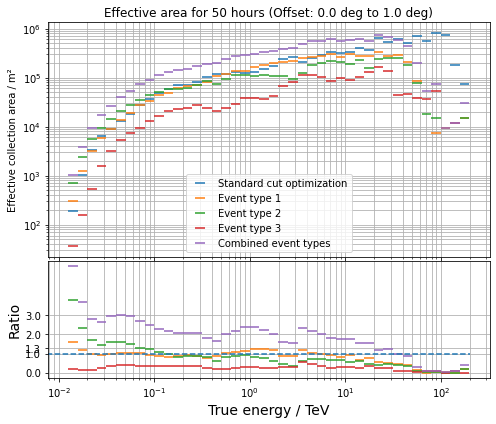

In [17]:
area = QTable.read(pyirf_file, hdu='EFFECTIVE AREA')[0]
y = area['EFFAREA'].to_value(u.m**2).T[1:-1, 0]
x = 0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1]
xerr = -0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1]

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)

axs.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")

def plot_effective_area_all(pyirf_file1, pyirf_file2, pyirf_file3, ref_y):
    area = QTable.read(pyirf_file1, hdu='EFFECTIVE AREA')[0]

    axs.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, offset],
        xerr=-0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 1",
    )
    axs_ratio.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, offset]/ref_y,
        xerr=-0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 1", color="C1"
    )
    
    area2 = QTable.read(pyirf_file2, hdu='EFFECTIVE AREA')[0]

    axs.errorbar(
        0.5 * (area2['ENERG_LO'] + area2['ENERG_HI']).to_value(u.TeV)[1:-1],
        area2['EFFAREA'].to_value(u.m**2).T[1:-1, offset],
        xerr=-0.5 * (area2['ENERG_LO'] - area2['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 2",
    )
    axs_ratio.errorbar(
        0.5 * (area2['ENERG_LO'] + area2['ENERG_HI']).to_value(u.TeV)[1:-1],
        area2['EFFAREA'].to_value(u.m**2).T[1:-1, offset]/ref_y,
        xerr=-0.5 * (area2['ENERG_LO'] - area2['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 2", color="C2"
    )
    
    area3 = QTable.read(pyirf_file3, hdu='EFFECTIVE AREA')[0]

    axs.errorbar(
        0.5 * (area3['ENERG_LO'] + area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        area3['EFFAREA'].to_value(u.m**2).T[1:-1, offset],
        xerr=-0.5 * (area3['ENERG_LO'] - area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 3",
    )
    axs_ratio.errorbar(
        0.5 * (area3['ENERG_LO'] + area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        area3['EFFAREA'].to_value(u.m**2).T[1:-1, offset]/ref_y,
        xerr=-0.5 * (area3['ENERG_LO'] - area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Event type 3", color="C3"
    )
        
    combined = area['EFFAREA'].to_value(u.m**2).T[1:-1, offset] \
               + area2['EFFAREA'].to_value(u.m**2).T[1:-1, offset] \
               + area3['EFFAREA'].to_value(u.m**2).T[1:-1, offset]
    axs.errorbar(
        0.5 * (area3['ENERG_LO'] + area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        combined,
        xerr=-0.5 * (area3['ENERG_LO'] - area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Combined event types",
    )
    
    axs_ratio.errorbar(
        0.5 * (area3['ENERG_LO'] + area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        combined/ref_y,
        xerr=-0.5 * (area3['ENERG_LO'] - area3['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label="Combined event types", color="C4"
    )
    
plot_effective_area_all(pyirf_file_event_type_1,pyirf_file_event_type_2, pyirf_file_event_type_3, y)
    
# Style settings
axs_ratio.set_xlabel("True energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_yticks([0., 1, 1.3, 2, 3])
axs.set_title('Effective area for 50 hours (Offset: {} to {})'.format(fov_min, fov_max))
axs.set_xscale("log")
axs.set_yscale("log")
axs.set_xlabel("")
axs.set_ylabel("Effective collection area / m²")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)
fig.show()
fig.savefig("EffectiveArea_by_ET_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

/tmp/ipykernel_195/1856649625.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(phi, r, image)


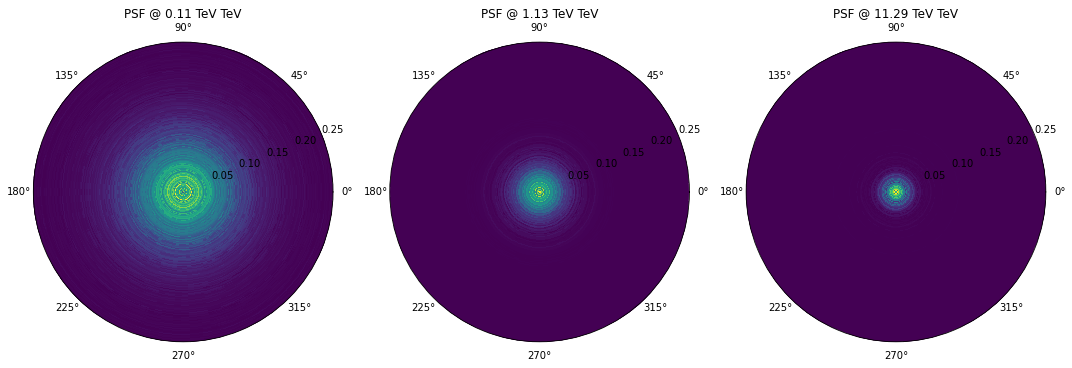

In [18]:
psf_table = QTable.read(pyirf_file_event_type_1, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, offset, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)

# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects

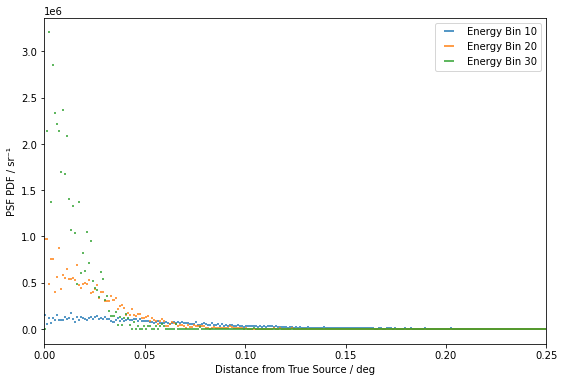

In [19]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')

None # to remove clutter by mpl objects

#### Angular resolution
[back to top](#Table-of-contents)

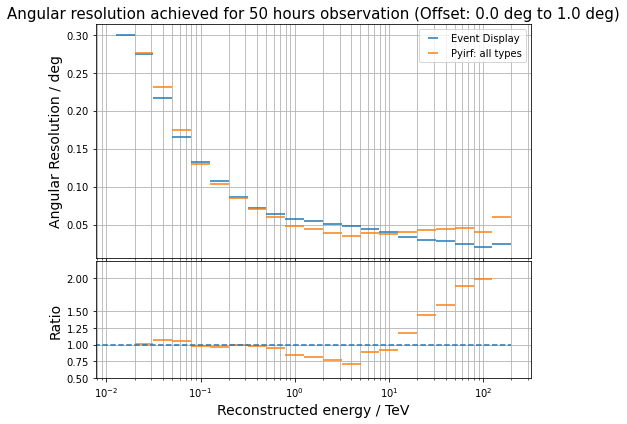

In [20]:
# Data from EventDisplay
y, edges, offset_bins = irf_eventdisplay["AngResEtrue_offaxis"].to_numpy()
y = y[:, offset]
yerr = irf_eventdisplay["AngResEtrue_offaxis"].errors()[:, offset]
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)


axs.errorbar(x, y, xerr=xerr, ls='', label="Event Display")

# pyirf
def plot_ang_res(pyirf_file, axis, axis_ratio, label, color, y_ref):
    ang_res = QTable.read(pyirf_file, hdu='ANGULAR RESOLUTION')[1:-1]

    axis.errorbar(
        0.5 * (ang_res['reco_energy_low'][:, offset] + ang_res['reco_energy_high'][:, offset]).to_value(u.TeV),
        np.array(ang_res['angular_resolution'][:, offset].to_value(u.deg)),
        xerr=0.5 * (ang_res['reco_energy_high'][:, offset] - ang_res['reco_energy_low'][:, offset]).to_value(u.TeV),
        ls='', color=color,
        label=label
    )
    axis_ratio.errorbar(
        0.5 * (ang_res['reco_energy_low'][:, offset] + ang_res['reco_energy_high'][:, offset]).to_value(u.TeV),
        np.array(ang_res['angular_resolution'][:, offset].to_value(u.deg)) / y_ref,
        xerr=0.5 * (ang_res['reco_energy_high'][:, offset] - ang_res['reco_energy_low'][:, offset]).to_value(u.TeV),
        ls='', color=color,
        label=label
    )

plot_ang_res(pyirf_file, axs, axs_ratio, "Pyirf: all types", "C1", y)


axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 2.25)
axs_ratio.set_yticks([0.50, 0.75, 1.0, 1.25, 1.5, 2])

# Style settings
axs.set_title('Angular resolution achieved for 50 hours observation (Offset: {} to {})'.format(fov_min, fov_max), fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel("Angular Resolution / deg", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)

fig.show()
fig.savefig("AngularResolution_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

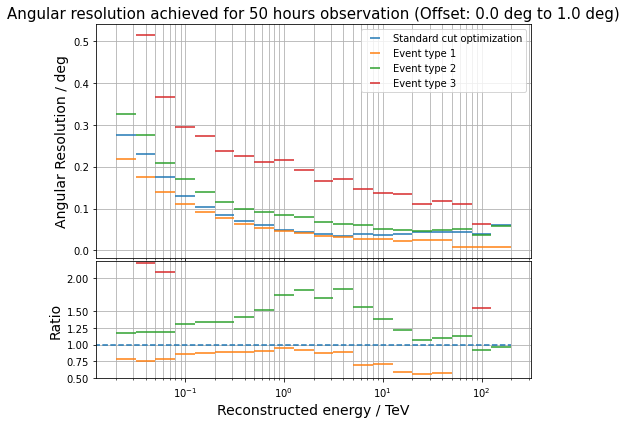

In [21]:
ang_res = QTable.read(pyirf_file, hdu='ANGULAR RESOLUTION')[1:-1]
y = np.array(ang_res['angular_resolution'][:, offset].to_value(u.deg))

x = 0.5 * (ang_res['reco_energy_low'][:, offset] + ang_res['reco_energy_high'][:, offset]).to_value(u.TeV)
xerr = 0.5 * (ang_res['reco_energy_high'][:, offset] - ang_res['reco_energy_low'][:, offset]).to_value(u.TeV)

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)


axs.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")

plot_ang_res(pyirf_file_event_type_1, axs, axs_ratio, "Event type 1", "C1", y)
plot_ang_res(pyirf_file_event_type_2, axs, axs_ratio, "Event type 2", "C2", y)
plot_ang_res(pyirf_file_event_type_3, axs, axs_ratio, "Event type 3", "C3", y)

axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 2.25)
axs_ratio.set_yticks([0.50, 0.75, 1.0, 1.25, 1.5, 2])

# Style settings
axs.set_title('Angular resolution achieved for 50 hours observation (Offset: {} to {})'.format(fov_min, fov_max), fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel("Angular Resolution / deg", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)

fig.show()
fig.savefig("AngularResolution_by_ET_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

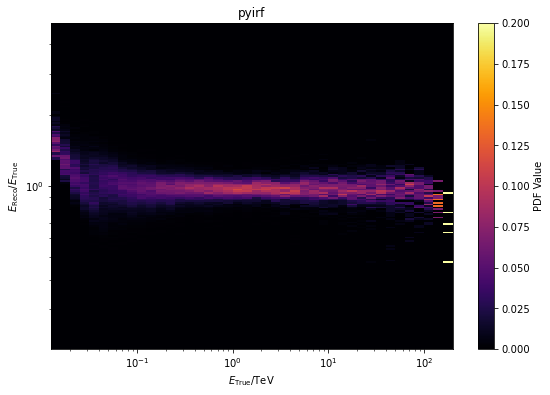

In [22]:
edisp = QTable.read(pyirf_file, hdu='ENERGY DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('pyirf')
plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, offset].T, cmap='inferno')

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

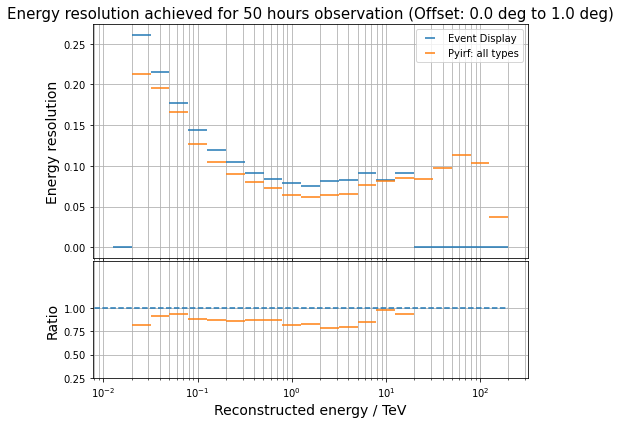

In [23]:
# Data from EventDisplay
y, edges, offset_bins = irf_eventdisplay["ERes_offaxis"].to_numpy()
y = y[:, offset]
yerr = irf_eventdisplay["ERes_offaxis"].errors()[:, offset]
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2

fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)

axs.errorbar(x, y, xerr=xerr, ls='', label="Event Display")


def plot_energy_resolution(pyirf_file, label, axis, axis_ratio, color, y_ref):
    # Data from pyirf
    bias_resolution = QTable.read(pyirf_file, hdu='ENERGY BIAS RESOLUTION')[1:-1]

    # Plot function
    axis.errorbar(
        0.5 * (bias_resolution['reco_energy_low'][:, offset] + bias_resolution['reco_energy_high'][:, offset]).to_value(u.TeV),
        bias_resolution['resolution'][:, offset],
        xerr=0.5 * (bias_resolution['reco_energy_high'][:, offset] - bias_resolution['reco_energy_low'][:, offset]).to_value(u.TeV),
        ls='',
        label=label
    )
    axis_ratio.errorbar(
        0.5 * (bias_resolution['reco_energy_low'][:, offset] + bias_resolution['reco_energy_high'][:, offset]).to_value(u.TeV),
        bias_resolution['resolution'][:, offset] / y_ref,
        xerr=0.5 * (bias_resolution['reco_energy_high'][:, offset] - bias_resolution['reco_energy_low'][:, offset]).to_value(u.TeV),
        ls='', color=color,
        label=label
    )
    
plot_energy_resolution(pyirf_file, "Pyirf: all types", axs, axs_ratio, "C1", y)


axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 1.5)
axs_ratio.set_yticks([0.25, 0.50, 0.75, 1.0])

# Style settings
axs.set_title('Energy resolution achieved for 50 hours observation (Offset: {} to {})'.format(fov_min, fov_max), fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel(r"Energy resolution", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)
fig.show()
fig.savefig("EnergyResolution_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

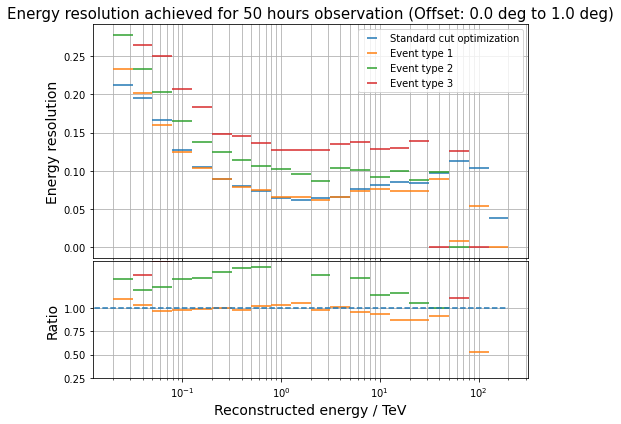

In [24]:
bias_resolution = QTable.read(pyirf_file, hdu='ENERGY BIAS RESOLUTION')[1:-1]
y = bias_resolution['resolution'][:, offset]
x = 0.5 * (bias_resolution['reco_energy_low'][:, offset] + bias_resolution['reco_energy_high'][:, offset]).to_value(u.TeV)
xerr = 0.5 * (bias_resolution['reco_energy_high'][:, offset] - bias_resolution['reco_energy_low'][:, offset]).to_value(u.TeV)


fig, (axs, axs_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [2, 1]},
    sharex=True,
    figsize=[7,6]
)

axs.errorbar(x, y, xerr=xerr, ls='', label="Standard cut optimization")

plot_energy_resolution(pyirf_file_event_type_1, "Event type 1", axs, axs_ratio, "C1", y)
plot_energy_resolution(pyirf_file_event_type_2, "Event type 2", axs, axs_ratio, "C2", y)
plot_energy_resolution(pyirf_file_event_type_3, "Event type 3", axs, axs_ratio, "C3", y)


# Style settings
axs_ratio.set_xlabel("Reconstructed energy / TeV", fontsize=14)
axs_ratio.set_ylabel('Ratio', fontsize=14)
axs_ratio.grid(which="both")
axs_ratio.yaxis.set_major_formatter(ScalarFormatter())
axs_ratio.plot([0, 200], [1, 1], '--')
axs_ratio.set_ylim(0.5, 1.5)
axs_ratio.set_yticks([0.25, 0.50, 0.75, 1.0])

axs.set_title('Energy resolution achieved for 50 hours observation (Offset: {} to {})'.format(fov_min, fov_max), fontsize=15)
axs.set_xscale("log")
# axs.set_yscale("log")
axs.set_ylabel(r"Energy resolution", fontsize=14)
axs.set_xlabel("")
axs.grid(which="both")
axs.legend()
fig.tight_layout(h_pad=0)
fig.show()
fig.savefig("EnergyResolution_by_ET_offset{}.pdf".format(offset))

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

/data/magic/users-ciemat/jbernete/anaconda3/envs/event_types/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


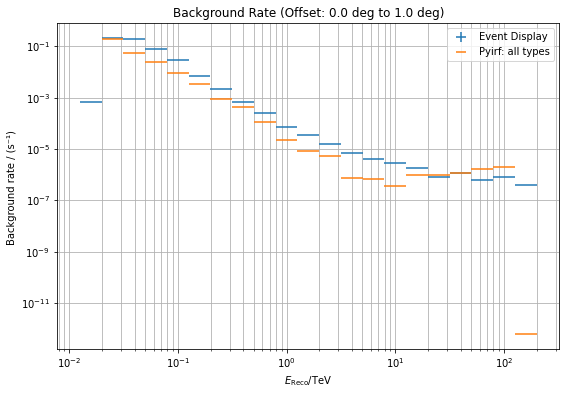

In [25]:
from pyirf.utils import cone_solid_angle

# Data from EventDisplay
y, edges, offset_bins = irf_eventdisplay["BGRate_offaxis"].to_numpy()
y = y[:, offset]
yerr = irf_eventdisplay["BGRate_offaxis"].errors()[:, offset]
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="Event Display")

def plot_bg_rate(pyirf_file, label):
    bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]
    theta_cut = QTable.read(pyirf_file, hdu='THETA_CUTS')

    reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

    rate_bin = bg_rate['BKG'].T[:, offset]

    # undo normalization
    rate_bin *= cone_solid_angle(theta_cut['cut'][:, offset].to('deg'))
    rate_bin *= np.diff(reco_bins)

    plt.errorbar(
        0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
        rate_bin.to_value(1 / u.s)[1:-1],
        xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
        ls='',
        label=label,
    )

plot_bg_rate(pyirf_file, "Pyirf: all types")

# Style settings
plt.title('Background Rate (Offset: {} to {})'.format(fov_min, fov_max))
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')
plt.savefig("BackgroundRate_offset{}.pdf".format(offset))


None # to remove clutter by mpl objects

/data/magic/users-ciemat/jbernete/anaconda3/envs/event_types/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/data/magic/users-ciemat/jbernete/anaconda3/envs/event_types/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/data/magic/users-ciemat/jbernete/anaconda3/envs/event_types/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/data/magic/users-ciemat/jbernete/anaconda3/envs/event_types/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


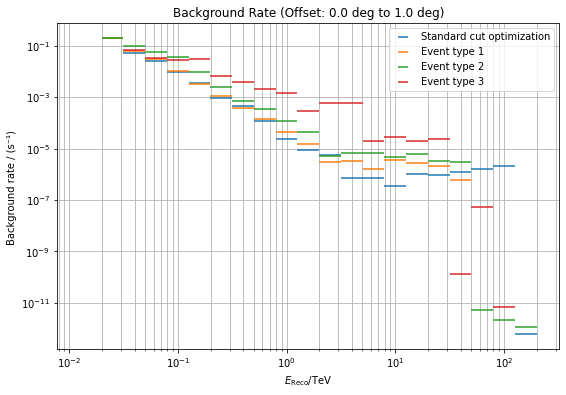

In [26]:
plot_bg_rate(pyirf_file, "Standard cut optimization")
plot_bg_rate(pyirf_file_event_type_1, "Event type 1")
plot_bg_rate(pyirf_file_event_type_2, "Event type 2")
plot_bg_rate(pyirf_file_event_type_3, "Event type 3")


# Style settings
plt.title('Background Rate (Offset: {} to {})'.format(fov_min, fov_max))
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')
plt.savefig("BackgroundRate_by_ET_offset{}.pdf".format(offset))


None # to remove clutter by mpl objects